<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Using_Pytorch_to_fight_cancer_(I).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pytorch to Fight Cancer

## 1. Training an image classifier

We will do the following steps in order:

1. Load and normalize the dataset training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

First, we check if GPU is connected. The `nvidia-smi` command (NVIDIA System Management Interface) is used to monitor and manage NVIDIA GPUs (Graphics Processing Units) in a system. It provides detailed information about the status and performance of the GPUs, including GPU utilization, temperature, memory usage, processes utilizing the GPU, and more.


`nvidia-smi` is a useful tool for monitoring and diagnosing the performance of NVIDIA GPUs in a system.

---

**[`nvidia-smi`](https://www.baeldung.com/linux/nvidia-smi-full-gpu-details)**

---

In [37]:
!nvidia-smi

Thu Jun 13 16:42:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              30W /  70W |    363MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Explanation of the output provided by the `nvidia-smi` command:

1. **Driver and CUDA Information**:
   - `Driver Version`: The version of the installed NVIDIA driver.
   - `CUDA Version`: The version of CUDA installed on the system.

2. **GPU Information**:
   - `GPU Name`: Name of the GPU.
   - `Persistence-M`: Indicates whether GPU persistence is enabled or disabled. Feature that allows NVIDIA GPUs to remain active and ready to process tasks even when there isn't a specific computing task to perform. Instead of powering off after completing a task, the GPU stays active in a low-power state, reducing downtime and the wait time for the GPU to be activated again when needed for a new task.
   - `Bus-Id`: GPU bus identifier.
   - `Disp.A`: Display state (on or off).
   - `Volatile Uncorr. ECC`: Volatile uncorrectable memory error correction.
   - `Fan`: GPU fan speed.
   - `Temp`: GPU temperature.
   - `Perf`: GPU performance.
   - `Pwr:Usage/Cap`: GPU power usage / Maximum power capacity.
   - `Memory-Usage`: GPU memory usage.
   - `GPU-Util`: GPU utilization.
   - `Compute M.`: GPU utilization for compute.
   - `MIG M.`: Multi-Instance GPU.

3. **Running Processes**:
   - Lists the running processes that are utilizing the GPU, if any.
   - `GPU`: GPU number the process is running on.
   - `GI`: GPU instance ID.
   - `CI`: Compute instance ID.
   - `PID`: Process ID.
   - `Type`: Process type.
   - `Process name`: Name of the running process.
   - `GPU Memory Usage`: GPU memory usage by the process.

In this particular case, there are no processes currently running that are utilizing the GPU, as indicated in the "Processes" section. The GPU is in an idle state, with a temperature of 52°C and a power usage of 10W out of a maximum of 70W. Additionally, no processes are currently using the GPU.

For example. To enable GPU persistence in NVIDIA, you can use the `nvidia-smi` command along with the `--persistence-mode` option. Here are the steps to enable GPU persistence:

---
**Enable GPU persistence**

---

In [38]:
!nvidia-smi --persistence-mode=1
!nvidia-smi

Enabled persistence mode for GPU 00000000:00:04.0.
All done.
Thu Jun 13 16:42:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              30W /  70W |    363MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+------

---
**Disable GPU Persistence**

---

In [39]:
!nvidia-smi --persistence-mode=0
!nvidia-smi

Disabled persistence mode for GPU 00000000:00:04.0.
All done.
Thu Jun 13 16:42:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              30W /  70W |    363MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----

### Setting our workspace: `/content` and `/content/datasets`

We save the root directory of the project '/content' as 'HOME' since we will be navigating through the directory to have multiple projects under the same HOME. Additionally, we will have the datasets in the 'dataset' directory, so all datasets are easily accessible for any project.

---
**Setting our Home**

---

In [40]:
import os
HOME = os.getcwd() # Obtain actual directory
print(HOME)

/content/datasets


Next, it imports the drive module from the google.colab library, which provides functionalities for mounting Google Drive in Google Colab.

Additionally, Google Drive is mounted in Google Colab and made available at the path /content/drive. The user will be prompted to authorize access to Google Drive. Once authorized, the content of Google Drive will be accessible from that point onwards in the Colab notebook.

In [41]:
# This cell it is not necessary run if you dont be in google colab
!pip install google_colab -q

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Load a dataset (dataloader)

Create the dataset directory (if it doesn't exist), where we are going to save the dataset with which we are going to train our CNN.

---
**Create a directory where we can save our dataset**

---

In [42]:
import os
datasets_dir = os.path.join(HOME, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
print(os.getcwd())

/content/datasets


Check if the file specified by `file` does not exist in the current directory. If it doesn't exist, the code block inside the conditional, which in this case would be downloading the file from the specified URL, is executed. then, it extracts the contents of `exp0.zip` into the current directory quietly, overwriting any existing files if necessary.

---
**Change to new directory datasets**

---

In [43]:
# Change to new dataset folder
os.chdir(datasets_dir)
print('dataset_dir =', os.getcwd())
if  not os.path.isfile('exp0.zip'):
  !wget -q https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
!unzip -qq -o exp0.zip

dataset_dir = /content/datasets/datasets


### Inspect the Dataset

The dataset contains several thousand photos of cell images in two subdirectories (classes) with one cell image per class. The directory structure is as follows thanks to this snipet:

---
**Display the datapath structure.**

---

In [44]:
import os

def print_directory_tree(root_dir, level=0):
    """
    Recursively prints the directory tree structure, only listing directories.
    """
    prefix = " " * (level * 4) + "|-- " if level > 0 else ""
    print(prefix + os.path.basename(root_dir))

    if os.path.isdir(root_dir):
        for item in os.listdir(root_dir):
            item_path = os.path.join(root_dir, item)
            if os.path.isdir(item_path):
                print_directory_tree(item_path, level + 1)

# Define the data directory
data_dir = datasets_dir

# Print the directory tree
print_directory_tree(data_dir)

datasets
    |-- __MACOSX
        |-- exp0
            |-- train
                |-- class_1
                |-- class_0
            |-- val
                |-- class_1
                |-- class_0
            |-- test
                |-- class_1
                |-- class_0
    |-- exp0
        |-- train
            |-- class_1
            |-- class_0
        |-- val
            |-- class_1
            |-- class_0
        |-- test
            |-- class_1
            |-- class_0


Now, we will use the `matplotlib` library to display multiple images in a 2x4 grid layout. Next code imports necessary modules, including `matplotlib.pyplot` for plotting, `glob` for file matching, and `matplotlib.image` for image handling.

It specifies the directory containing the images and retrieves the paths of the first 8 `.jpg` images in that directory using `glob.glob()`.

Then, it creates a figure with subplots arranged in a 2x4 grid and iterates through the image paths, displaying each image in a subplot using `imshow()`. The title of each subplot is set to indicate the image index, and axis labels are turned off.

After displaying all images, it adjusts the layout to prevent overlapping and shows the figure.

Finally, it prints the size of the last image processed.

---
**Display 8 images from a class from test**

---

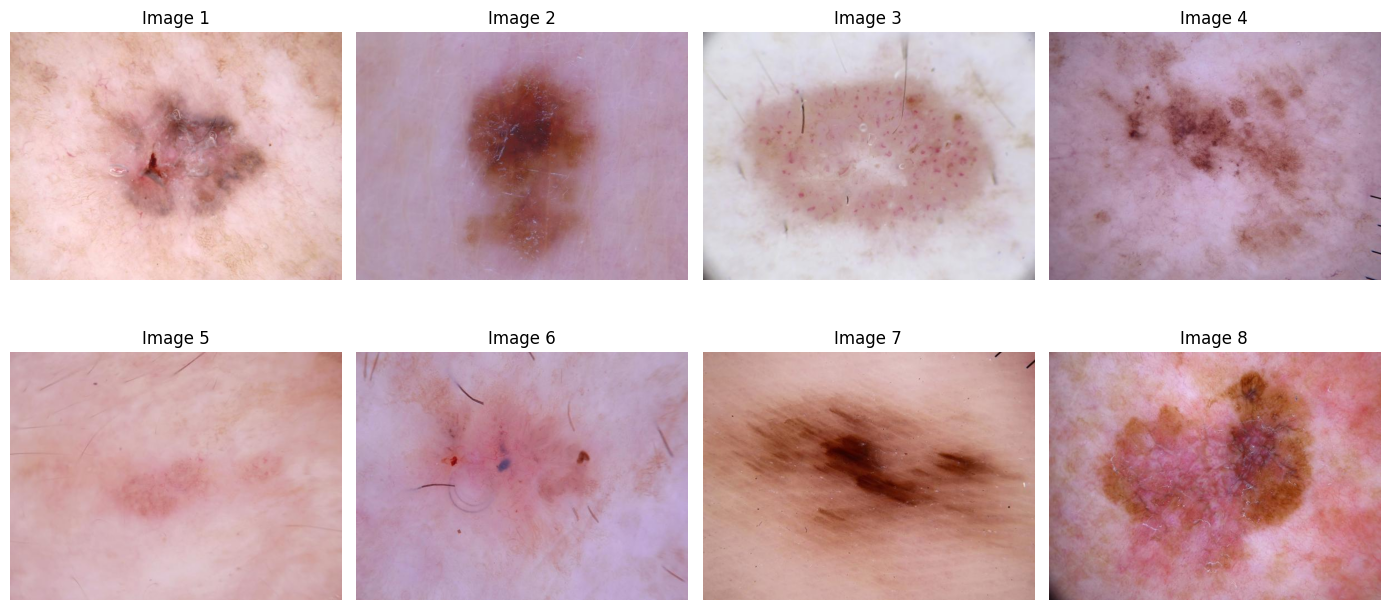


 Size of image:  (450, 600, 3)


In [45]:
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# Directory of the images
image_directory = datasets_dir + '/exp0/test/class_1/'

# List of image paths
image_paths = glob.glob(image_directory + '*.jpg')[:8]

# Set up the figure with subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

# Iterate through the images and display them in the subplots
for i, image_path in enumerate(image_paths):
    row = i // 4
    col = i % 4
    img = mpimg.imread(image_path)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'Image {i + 1}')
    axs[row, col].axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()
print("\n Size of image: ", img.shape)

### Setting a Dataloader

The purpose of a **DataLoader** is fundamental in the context of machine learning and deep learning, especially when working with large or complex datasets. Its main purpose is to facilitate the efficient loading and manipulation of data during model training.

Here are some key purposes of a DataLoader:

1. **Efficient data loading**: DataLoaders enable loading data in batches, meaning that instead of loading the entire dataset into memory at once, data is loaded in small batches. This optimizes memory usage and allows working with datasets that wouldn't fit entirely in RAM.

2. **Data preprocessing**: DataLoaders can apply transformations to the data in real-time while loading, such as normalization, resizing, cropping, rotation, among others. This simplifies the data preprocessing process and helps ensure consistency in the application of transformations.

3. **Data shuffling and randomization**: When training a model, it's common to shuffle the data to prevent the model from memorizing patterns sequentially. DataLoaders can randomize the order of the data in each epoch (complete iteration through the dataset), which helps improve the model's generalization.

4. **Parallel data loading**: In systems with multiple CPU or GPU cores, DataLoaders can load data in parallel, making full use of available hardware resources and reducing wait time during data loading.

5. **User-friendly interface**: DataLoaders provide a simple and uniform interface for accessing data during model training. This facilitates implementation and maintenance of code, as developers can focus on the model logic rather than data manipulation.

In summary, DataLoaders are an essential tool for efficiently training machine learning and deep learning models, as they simplify data loading, preprocessing, and manipulation, allowing developers to focus on model creation and optimization.

---
**Load Libraries for DataLoader**

---

In [46]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm # progress bar

 Next, we will sets up a data loader using PyTorch and torchvision for handling datasets. Here's a summary of what each line does:

- `torch`: The core PyTorch library.
- `torchvision`: Provides datasets, models, and transformations for computer vision tasks.
- `DataLoader`: From `torch.utils.data`, loads datasets in batches.
- `datasets`: From `torchvision`, accesses standard datasets like MNIST, CIFAR-10, etc.
- `transforms`: From `torchvision`, contains image transformations.
- `tqdm`: Displays progress bars during iterations.

### Train, Val y Test Sets

In machine learning, it is common to divide the dataset into three main parts: training set, validation set and test set. Here I explain each of them:

- **Train Set**: This dataset is used to train the model. That is, the model learns from this data by adjusting its parameters to minimise the loss function. The model is iteratively fitted to this data set during training, using optimisation techniques such as gradient descent. Generally, the training set is the largest, as an adequate amount of data is required for the model to learn meaningful patterns.
- **Validation Set**: After training the model with the training set, the validation set is used to adjust the hyperparameters of the model and evaluate its performance. The `val` set is used to select the best model among several possible configurations, avoiding overfitting to the test set. This dataset is used to adjust the model architecture, learning rate or other hyperparameters, in order to obtain a generalisable model.
- **Test Set**: This data set is used to check the final performance of the model after it has been trained and evaluated. The test set is essentially a stand-alone data set that the model has not seen during training or evaluation. It provides an objective estimate of the model's performance on unseen data and helps assess its ability to generalise to new samples.

It is a good practice to normalize both the training set and the val set in the same way. This ensures that the data are on the same scale and distribution, which can help the model converge more quickly during training and make more consistent predictions during evaluation.

It is important to remember that when normalizing the data, you need to calculate the mean and standard deviation only on the training set and then apply those same statistics to the test set. This is because the validation set should simulate "new" or "unknown" data for the model, so it should not be used to calculate any normalization statistics.

Therefore, after calculating the mean and standard deviation on the training set, you can normalize both the training set and the test set as follows:

1. Calculate the mean and standard deviation on the training set.
2. Normalize the training set using these statistics.
3. Normalize the test set using the same statistics calculated on the training set.



**Note**: These time magics (%time and %%time) will give you information about how long it takes to execute the code in the respective cell in Google Colab. The results will be displayed below the cell after the execution is completed.

---
**Create a Dataloader for train, val y test sets**

---

In [47]:
%%time

# 1. Calculate the mean and standard deviation on the training set.
# train, validation and test data directory

train_dir = datasets_dir + '/exp0/train/'
val_dir = datasets_dir + '/exp0/test/'
test_dir = datasets_dir + '/exp0/val/'

# transform to calculate mean and standard desviation
transform = transforms.Compose([
    transforms.ToTensor()  # transform images to tensor
])

# Load the ImageFolder dataset and apply the transformation
dataset = datasets.ImageFolder(root= train_dir, transform=transform)

# it's better to use a loader to retrieve images (tensors)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize variables to store the sum of pixel values and
# standard deviation.
# These variables are set to floating-point zeros to ensure
# accurate calculations.
mean_sum = 0.0
std_sum = 0.0
total_samples = 0

# Iterates over the data loader (loader),
# calculates the mean and standard deviation across all channels
# for each batch(0) and spatial dimensions (height(2) and width(3))
for images, _ in loader:
    mean_sum += torch.mean(images, dim=[0, 2, 3])
    std_sum += torch.std(images, dim=[0, 2, 3])
    total_samples += 1

mean = mean_sum / total_samples
std = std_sum / total_samples

print("Total train samples:", total_samples)
print("Mean:", mean)
print("Std:", std)

Total train samples: 2700
Mean: tensor([0.7513, 0.5535, 0.5788])
Std: tensor([0.0921, 0.1196, 0.1349])
CPU times: user 28.4 s, sys: 175 ms, total: 28.6 s
Wall time: 38.4 s


---
**Normalize the dataloaders using Statistics**

---

In [48]:
%%time

# 2. Normalize the training set using these statistics.


train_set = datasets.ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

# 3. Normalize the test and validation set using the same statistics
# calculated on the training set.
val_set = datasets.ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

test_set = datasets.ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

# Data modified in any way?

print(f"Length of Train Data :{len(train_set)}")
print(f"Length of Validation Data : {len(val_set)}")
print(f"Length of Test Data : {len(test_set)}")

classes = train_set.classes
print('Classes: ', classes)



Length of Train Data :2700
Length of Validation Data : 600
Length of Test Data : 300
Classes:  ['class_0', 'class_1']
CPU times: user 10.3 ms, sys: 1.88 ms, total: 12.2 ms
Wall time: 11.9 ms


The train set is unmodified in size because `transform()` transform the data but it don't augment the dataset

### Displaying all classes

Let us show one example for each class, for fun. As we've transformed the image by normalizing it, we should undo the transformation before visualizing the image.

---
**Display one example from each class**

---


CPU times: user 3.88 s, sys: 55.1 ms, total: 3.94 s
Wall time: 3.92 s


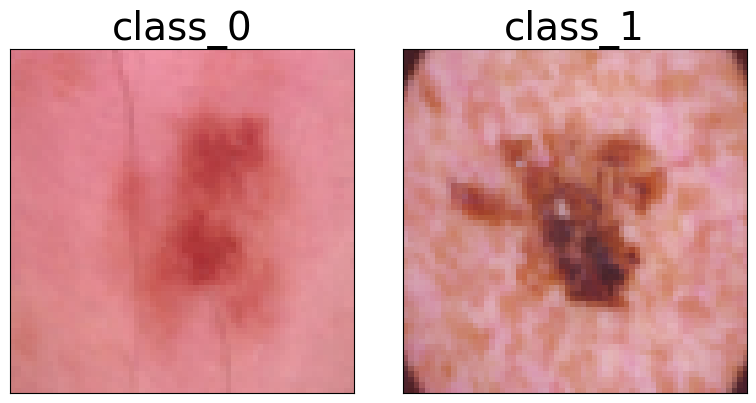

In [49]:
%%time

# unnormalize function in order to display correctly
inv_normalize = transforms.Normalize(
  mean= [-m/s for m, s in zip(mean, std)],
  std= [1/s for s in std]
)

fig, ax = plt.subplots(nrows=1, ncols=len(classes), figsize=(2*4,1*4),
                       subplot_kw={'facecolor': "#ebf5ff"})

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[i], fontsize=28)
  img = next(img for img,label in train_set if label == i)
  #ax.imshow(img.permute(1,2,0)) # for normalized channels
  ax.imshow(inv_normalize(img).permute(1,2,0)) # for unnormalized

fig.tight_layout()

### Settings Hyperparameters

Hyperparameters are parameters that are not directly learned from the training process of the model but are set before the training process begins. They are configurations that control the training process of the model and affect its performance and behavior.

Here are some key characteristics of hyperparameters:

1. **Not directly learned**: Unlike model parameters, such as weights in a neural network, which are adjusted during training to minimize a loss function, hyperparameters are not directly adjusted during training. Instead, they are set before training begins and remain constant throughout the training process.

2. **Control the model's behavior**: Hyperparameters influence how the model learns during training. They can affect aspects such as the convergence speed of the model, its ability to generalize to unseen data (generalization), its ability to avoid overfitting, and other aspects of model performance.

3. **Examples of hyperparameters**: Some common examples of hyperparameters include the learning rate in optimization algorithms, the number of layers and neurons in a neural network, the batch size in batch training, regularization parameters like L1 or L2 penalty, and many other settings that may vary from one model to another.

4. **Hyperparameter tuning**: In practice, hyperparameter tuning is an important step in the development of machine learning and deep learning models. It involves searching for optimal combinations of hyperparameter values to maximize the model's performance on a given dataset. This can be done using methods such as grid search, random search, Bayesian optimization, among others.

In summary, hyperparameters are configurations that control the behavior of the model during training and are set before the training process. They are critical for optimizing the performance and generalization of the model across different datasets and problems.

We are going to define some training parameters for the network, such as the number of batches, epochs, and classes in the dataset because they are needed for dataloaders in order to set up our training loop.

---
**Define batch_size, epochs and obtain the number of classes**

---

In [50]:
# batch size defines how many training or testing samples
# to use in a single iteration
batch_size = 32
# epochs define the number of iterations
epochs = 100
# num_classes define the number of the class
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")

Number of Classes: 2


----
**Define the train and test loaders for the training loop**

---

In [51]:
%%time

# Create dataloaders object for training/val loop.

train_dataloader = DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=True,
  num_workers=2)

val_dataloader = DataLoader(
  val_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)

CPU times: user 131 µs, sys: 9 µs, total: 140 µs
Wall time: 145 µs




Now, we define a function to obtain ncols and nrows need for a given number of images in order to display them.

---
**Define a small function to determine the columns and rows needed for a given number of images**

---

In [52]:
# We define a small function to determine the columns and rows needed
# for a given number of images.
def rows_cols(input):

    divisors = []

    # Realize a little operation with input
    # in order to determine divisors for input
    for i in range(1, input+1): # not divide by 0
        if input % i == 0:
            divisors.append(i)

    # divisors list size
    n = len(divisors)

    # If the size is odd, the element in the middle is the median value.
    if n % 2 != 0:
        median_index = (n - 1) // 2
        rows = divisors[median_index]
    # If the size is even, the two elements in the middle are equal
    else:
        median_index1 = n // 2 - 1
        rows = divisors[median_index1]

    cols = int(input/rows)
    return rows, cols


To see how the DataLoader works and how it handles the loaded data, we will select a random batch and display it, indicating its class label as well. It is said, we can display all images and its ground truth from a random batch in a easy way with dataloaders.

---
**Display all images and its ground truth from a random batch**

---

CPU times: user 819 ms, sys: 253 ms, total: 1.07 s
Wall time: 5.3 s


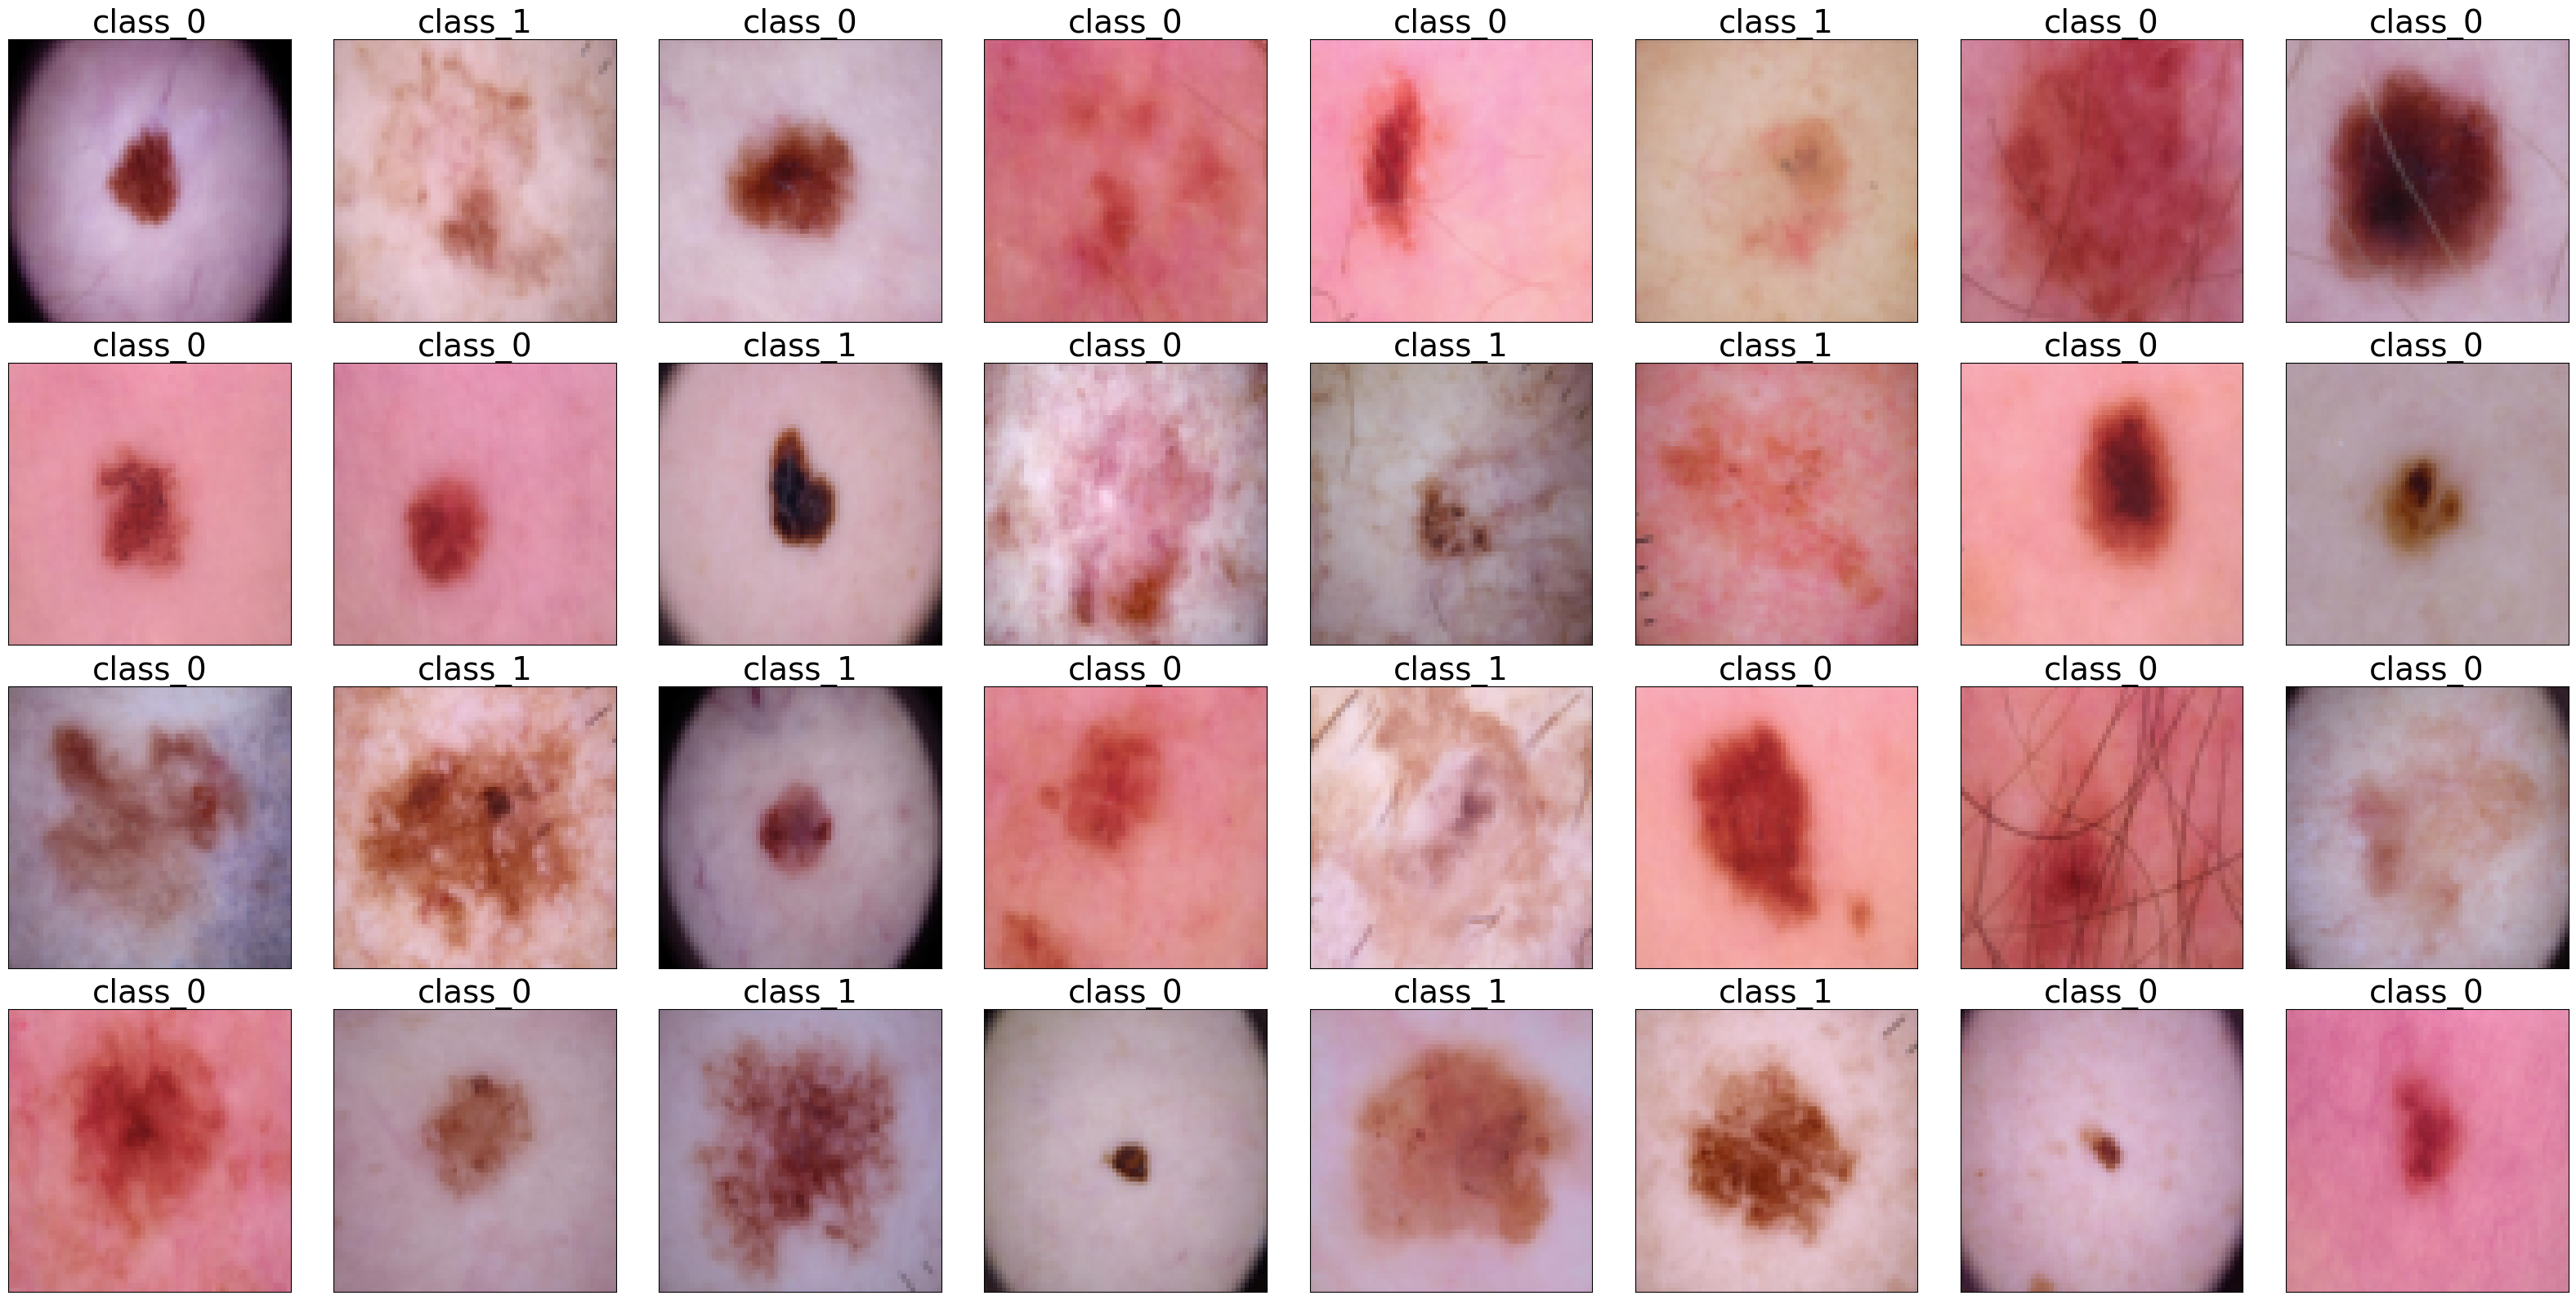

In [53]:
%%time

import itertools
import numpy as np
import os

nrows,ncols = rows_cols(batch_size)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),
                       subplot_kw={'facecolor': "#ebf5ff"})
rb_index = np.random.randint(0, len(train_dataloader))

# Obtener el batch correspondiente al índice aleatorio
imgs, labels = next(itertools.islice(train_dataloader, rb_index, rb_index+1))

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[labels[i]], fontsize=28)
  #ax.imshow(imgs[i].permute(1,2,0)) # for unnormalized
  ax.imshow(inv_normalize(imgs[i]).permute(1,2,0)) # for unnormalized

fig.tight_layout()




## 3. Define a [Convolutional Neural Network](https://pytorch.org/docs/stable/nn.html)


A Convolutional Neural Network (CNN) is a type of deep learning model specifically designed for processing structured grid data, such as images. It is composed of multiple layers of neurons that systematically process input data in a hierarchical manner, with each layer learning increasingly abstract features.

Here's a brief overview of the key components of a CNN:

1. **Convolutional Layers**: These layers consist of filters (also called kernels) that slide across the input data and perform convolution operations. The filters learn to detect patterns or features such as edges, textures, or shapes in the input data.

2. **Activation Functions**: After the convolution operation, an activation function like ReLU (Rectified Linear Unit) is typically applied to introduce non-linearity into the model, allowing it to learn complex relationships in the data.

3. **Pooling Layers**: Pooling layers reduce the spatial dimensions of the feature maps produced by the convolutional layers. Max pooling and average pooling are common pooling operations used to downsample the feature maps while preserving the most important information.

4. **Fully Connected Layers**: These layers take the flattened output from the convolutional and pooling layers and perform classification or regression tasks. They are typically composed of dense layers, which are fully connected layers of neurons.

5. **Output Layer**: The final layer of the CNN produces the model's predictions. The activation function used in this layer depends on the type of task being performed (e.g., softmax for classification or linear for regression).

CNNs have revolutionized the field of computer vision and have been widely adopted for tasks such as image classification, object detection, image segmentation, and more. Their ability to automatically learn hierarchical representations from raw data makes them highly effective for a wide range of visual recognition tasks.

The importance of the volumes generated by a Convolutional Neural Network (CNN) increases as the network deepens due to several key factors:

1. **Hierarchical Feature Representation**: In a CNN, the initial layers are specialized in detecting simple features such as edges and textures, while deeper layers learn to combine these simple features to form more complex and abstract representations of objects in the images. These hierarchical representations are crucial for the network's ability to understand and recognize patterns in the input data.

2. **Dimensionality Reduction**: As images pass through the convolutional and pooling layers, the dimensions of the feature volumes (or feature maps) may decrease. This is especially true if a large filter size or aggressive pooling layers are used. Dimensionality reduction helps to concentrate relevant information and simplifies processing in later layers of the network.

3. **Extraction of Relevant Features**: Deeper layers of the CNN typically have smaller but denser feature volumes. These volumes contain more abstract and information-rich representations that are crucial for the recognition task the network is performing. A mistake in the network design that causes premature loss of important features could significantly compromise the model's performance.

It's important to be careful when designing the architecture of a CNN to avoid errors that may lead to premature loss of information in the data volumes. Some common errors that can result in data volume loss include:

1. **Using Overly Aggressive Pooling Layers**: Employing pooling layers with too large a window size or too large a stride can reduce the size of the feature volume too quickly, resulting in the loss of relevant information in the process.

2. **Inadequate Dimensions of Convolutional Layers**: The dimensions of the convolutional filters and the padding used can influence the dimensions of the resulting feature volume. Poorly adjusting these dimensions can result in excessive information loss.

3. **Inappropriate Depth of the Network**: A network that is either too shallow or too deep can compromise performance. A network that is too shallow may not capture enough relevant features, while a network that is too deep may suffer from overfitting and a higher likelihood of premature loss of information.

Import the necessary modules from the `PyTorch library` for defining neural network architectures. Here's what each part means:

`import torch.nn as nn`: This line imports the torch.nn module, which contains pre-defined neural network layers, loss functions, and other utility functions for building neural networks. By importing nn, we gain access to classes such as Conv2d, Linear, MaxPool2d, etc., which are used to define the layers of a neural network.

`import torch.nn.functional as F`: This line imports the torch.nn.functional module, which contains functional versions of neural network operations. Functions like F.relu, F.softmax, F.sigmoid, etc., are commonly used inside the forward method of a neural network to apply non-linearities and other operations to the input data.

In summary, these import statements provide access to the tools and functions needed to define and train neural network models using PyTorch.

In [54]:
import torch.nn as nn
import torch.nn.functional as F

The output volume of a convolutional layer is determined by several factors, including the kernel size, padding, stride, and the dimensions of the input tensor.

For the `nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)` layer, let's assume the input has a size of `(batch_size, 32, H, W)`, where `batch_size` is the batch size, `32` is the number of input channels (feature maps), `H` is the height of the image, and `W` is the width of the image.

The output size is calculated using the following formula:

$$
\text{Output} = \left\lfloor \frac{\text{Input} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

Substituting the values for this layer:

- `Input`: (32, H, W) (32 input channels)
- `padding`: 1 (padding=1)
- `kernel_size`: 3 (kernel_size=3)
- `stride`: 1 (stride=1)

Then, the calculation would be:

$$
\text{Output} = \left\lfloor \frac{{32 + 2 \times 1 - 3}}{1} \right\rfloor + 1 = \left\lfloor \frac{{32}}{1} \right\rfloor + 1 = 32
$$

Therefore, the output will have a size of `(batch_size, 64, 32, 32)`, meaning that for each sample in the batch, there will be 64 feature maps of size 32x32.

Let's define a CNN by carefully examining its output volumes.

---
**Define the model**

---

In [55]:
# Large Model
class myCNN(nn.Module):
    def __init__(self): # defines the constructor method __init__()
                        # for the myCNN class. This method is called
                        # when an instance of the class is created.
        super().__init__() # calls the constructor of the parent class
                           # (nn.Module) using Python's super() function.
                           # It initializes the parent class, allowing the
                           # myCNN class to inherit functionality from nn.Module.

        self.network = nn.Sequential(

            # Layer 1: Conv2d
            # Input: (batch_size, 3, 64, 64)
            # Output: (batch_size, 32, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Layer 2: Conv2d
            # Input: (batch_size, 32, 64, 64)
            # Output: (batch_size, 64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 3: MaxPool2d
            # Input: (batch_size, 64, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.MaxPool2d(2, 2),

            # Layer 4: Conv2d
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 5: Conv2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 6: MaxPool2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.MaxPool2d(2, 2),

            # Layer 7: Conv2d
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 8: Conv2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 9: MaxPool2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.MaxPool2d(2, 2),

            # Layer 10: Flatten
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 16384)
            nn.Flatten(),

            # Layer 11: Linear
            # Input: (batch_size, 16384)
            # Output: (batch_size, 128)
            nn.Linear(16384, 128),
            nn.ReLU(),

            # Layer 12: Linear
            # Input: (batch_size, 128)
            # Output: (batch_size, 64)
            nn.Linear(128, 64),
            nn.ReLU(),

            # Layer 13: Linear
            # Input: (batch_size, 64)
            # Output: (batch_size, 2)
            nn.Linear(64, 2)
        )
    # The forward method takes a single argument xb,
    # which represents the input data to the neural network.
    # Inside the forward method, the input xb is passed through the
    # neural network layers defined in self.network. The result of this
    # computation is then returned as the output of the forward method.
    def forward(self, xb):
        return self.network(xb)


Here's the **equivalent functional definition** of the provided CNN.

In this functional definition, we use PyTorch's functional API (`torch.nn.functional`) to define each layer's operations. The code structure follows the same sequence of operations as in the original CNN, but without the need for the `nn.Sequential` container. Each layer's output is passed directly to the next layer's operation, just like in the object-oriented implementation. Finally, the output of the last layer is returned as the output of the `myCNN` function.

---
**In functional definition**

---

In [56]:
# Funtional definition for large model

def myCNN2(xb):
    # Layer 1: Conv2d
    out = F.relu(F.conv2d(xb, 32, kernel_size=3, padding=1))

    # Layer 2: Conv2d
    out = F.relu(F.conv2d(out, 64, kernel_size=3, stride=1, padding=1))

    # Layer 3: MaxPool2d
    out = F.max_pool2d(out, 2, 2)

    # Layer 4: Conv2d
    out = F.relu(F.conv2d(out, 128, kernel_size=3, stride=1, padding=1))

    # Layer 5: Conv2d
    out = F.relu(F.conv2d(out, 128, kernel_size=3, stride=1, padding=1))

    # Layer 6: MaxPool2d
    out = F.max_pool2d(out, 2, 2)

    # Layer 7: Conv2d
    out = F.relu(F.conv2d(out, 256, kernel_size=3, stride=1, padding=1))

    # Layer 8: Conv2d
    out = F.relu(F.conv2d(out, 256, kernel_size=3, stride=1, padding=1))

    # Layer 9: MaxPool2d
    out = F.max_pool2d(out, 2, 2)

    # Layer 10: Flatten
    out = out.view(out.size(0), -1)

    # Layer 11: Linear
    out = F.relu(F.linear(out, 16384, 128))

    # Layer 12: Linear
    out = F.relu(F.linear(out, 128, 64))

    # Layer 13: Linear
    out = F.linear(out, 64, 2)

    return out



In this modified version:

- I added Batch Normalization layers (`nn.BatchNorm2d` for convolutional layers and `nn.BatchNorm1d` for fully connected layers) after each activation function to stabilize and accelerate training.
- Dropout layers (`nn.Dropout2d` for convolutional layers and `nn.Dropout` for fully connected layers) were introduced after each activation function to prevent overfitting.
- I adjusted the input size of the first fully connected layer (`nn.Linear`) based on the output size of the previous layer's `Flatten` operation.
- The dropout rate for fully connected layers was set to 0.5, which is a common value for dropout rates in practice.

Feel free to adjust the hyperparameters, such as dropout rates or batch normalization momentum, to further optimize the model's performance based on your specific dataset and training settings. Additionally, you may experiment with different optimizer configurations and learning rate schedules to find the best training setup for your model.

---
**Improved Model**

---

In [57]:
class myImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            # Layer 1: Convolutional
            # Input: (batch_size, 3, 64, 64)
            # Output: (batch_size, 32, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Add Batch Normalization
            nn.ReLU(),

            # Layer 2: Convolutional
            # Input: (batch_size, 32, 64, 64)
            # Output: (batch_size, 64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Add Batch Normalization
            nn.ReLU(),

            # Max Pooling
            # Input: (batch_size, 64, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.MaxPool2d(2, 2),

            # Dropout
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 64, 32, 32)
            nn.Dropout2d(0.25),

            # Layer 3: Convolutional
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Add Batch Normalization
            nn.ReLU(),

            # Layer 4: Convolutional
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Add Batch Normalization
            nn.ReLU(),

            # Max Pooling
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.MaxPool2d(2, 2),

            # Dropout
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 128, 16, 16)
            nn.Dropout2d(0.25),

            # Layer 5: Convolutional
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Add Batch Normalization
            nn.ReLU(),

            # Layer 6: Convolutional
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Add Batch Normalization
            nn.ReLU(),

            # Max Pooling
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.MaxPool2d(2, 2),

            # Dropout
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 256, 8, 8)
            nn.Dropout2d(0.25),

            # Flatten
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 16384)
            nn.Flatten(),

            # Layer 7: Fully Connected (Linear)
            # Input: (batch_size, 16384)
            # Output: (batch_size, 128)
            nn.Linear(16384, 128),
            nn.BatchNorm1d(128),  # Add Batch Normalization for fully connected layers
            nn.ReLU(),

            # Dropout
            # Input: (batch_size, 128)
            # Output: (batch_size, 128)
            nn.Dropout(0.5),

            # Layer 8: Fully Connected (Linear)
            # Input: (batch_size, 128)
            # Output: (batch_size, 64)
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),  # Add Batch Normalization for fully connected layers
            nn.ReLU(),

            # Dropout
            # Input: (batch_size, 64)
            # Output: (batch_size, 64)
            nn.Dropout(0.5),

            # Layer 9: Fully Connected (Linear)
            # Input: (batch_size, 64)
            # Output: (batch_size, 2)
            nn.Linear(64, 2)
        )

    def forward(self, xb):
        return self.network(xb)


### Setting the Computing Device

This code sets up the device (CPU or GPU) for running the neural network and creates an instance of the `myCNN` model, moves it to the selected device, and optionally utilizes data parallelism if multiple GPUs are available.

Here's a detailed explanation of the code:

1. **Device Selection**: The code checks if CUDA (NVIDIA's parallel computing platform) is available on the system. If CUDA is available, the device is set to "cuda"; otherwise, it's set to "cpu". This allows the code to run on the GPU if available, which typically speeds up the training of neural network models.

2. **Model Creation**: An instance of the `myCNN` model is created. Then, the model is moved to the selected device using the `.to(device)` method. This ensures that all operations of the model are performed on the appropriate device (CPU or GPU).
= myCNN().to(device)

3. **Data Parallelism (Optional)**: If there's more than one GPU available (`torch.cuda.device_count() > 1`), a message indicating the number of available GPUs is printed, and `nn.DataParallel` is used to parallelize calculations across multiple GPUs. This automatically divides the data and operations in the network among the available GPUs, which can speed up model training in multi-GPU environments.

4. **Model Printing**: Finally, the model is printed, providing a detailed description of its architecture, including parameters and layers. This facilitates model verification and debugging.


In summary, this code prepares the model for training or inference on the selected device (CPU or GPU), and in case of multiple GPUs, allows data parallelism to speed up the training process.


Let's change the execution environment to T4.

---
**Setting CUDA environment**

---

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = myCNN().to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

print(model)


Using cuda device
myCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear

`torchsummary` is a Python library that provides a summary of a PyTorch model's architecture, including details such as the number of parameters, the output shape of each layer, and the total memory consumption.

Here's what `torchsummary` does:

1. **Model Summary**: It generates a concise summary of the PyTorch model, displaying information about each layer, such as the layer type, input shape, output shape, number of parameters, and memory usage.

2. **Layer Details**: For each layer in the model, `torchsummary` provides detailed information about its configuration, including kernel size, stride, padding, and activation function.

3. **Total Parameters**: It calculates and displays the total number of trainable parameters in the model, which is useful for understanding the model's complexity and memory requirements.

4. **Total Memory Consumption**: `torchsummary` estimates the total memory consumption of the model, which can be helpful for optimizing memory usage, especially when working with large models or limited hardware resources.

In summary, `torchsummary` is a valuable tool for gaining insights into the architecture and memory requirements of PyTorch models, making it easier to understand, debug, and optimize neural network architectures.

---
**Display the summary of our model**

---

In [59]:
!pip install torchsummary -q

from torchsummary import summary

summary(model, (3,64,64)) # input = [3,64,64]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

`torchviz` is a Python library used for visualizing PyTorch computational graphs. It provides a convenient way to visualize the flow of data through a neural network model, making it easier to understand and debug complex architectures.

Here's what `torchviz` does:

1. **Graph Visualization**: `torchviz` generates visual representations of PyTorch computational graphs, showing the connections between different layers and operations in the model.

2. **Layer Relationships**: It visually depicts the relationships between different layers in the model, including how the input data flows through the layers and how the output is generated.

3. **Debugging**: Visualizing the computational graph with `torchviz` can help in debugging neural network architectures by allowing developers to inspect the structure of the model and identify any potential issues or errors.

4. **Model Understanding**: `torchviz` aids in understanding the inner workings of a PyTorch model, providing insights into how data is transformed as it passes through the layers of the network.

Overall, `torchviz` is a valuable tool for visualizing and understanding PyTorch models, especially for developers and researchers working on deep learning projects.

---
**Obtain a graphical view of our model**

---

In [60]:
!pip install -q torchviz

In [61]:
from torchviz import make_dot

# Creamos un tensor de entrada
x = torch.randn(batch_size, 3, 64, 64, device=device)

# Obtenemos la salida de la red neuronal
y = model(x)

# Visualizamos el grafo de cálculo de la red neuronal
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render(filename='myCNN', format='png')

'myCNN.png'

### Define a Loss function and optimizer
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html). Let's use a Classification Cross-Entropy loss and SGD with momentum.

A loss function, also known as a cost function or objective function, measures the discrepancy between the predicted output of a model and the actual target values in the training dataset. It quantifies how well the model is performing and provides feedback to the optimization algorithm during training.

An optimizer, on the other hand, is responsible for updating the parameters of the model (e.g., weights and biases) based on the gradients of the loss function with respect to those parameters. The goal of the optimizer is to minimize the loss function, thereby improving the model's performance on the task at hand.

#### Common Loss Functions and Optimizers in Deep Learning with PyTorch

In PyTorch, selecting the appropriate loss function and optimizer are crucial aspects for effectively training a Deep Learning model. These tools enable the evaluation of model performance and adjusting its parameters to minimize error and enhance accuracy.

##### Common Loss Functions in PyTorch:

1. **`nn.MSELoss` (Mean Squared Error Loss):** Primarily used in regression tasks, where the goal is to predict continuous values. It measures the average squared difference between the predicted and actual values.

```python
criterion = nn.MSELoss()
```

2. **`nn.BCELoss` (Binary Cross-Entropy Loss):** Employed in binary classification tasks, where the model classifies each input into two categories. It calculates the entropy of the probability distribution predicted by the model compared to the true distribution.

```python
criterion = nn.BCELoss()
```

3. **`nn.CrossEntropyLoss` (Categorical Cross-Entropy Loss):** A generalization of `nn.BCELoss` for multi-class classification problems. It measures the categorical cross-entropy between the predicted and true probability distributions.

```python
criterion = nn.CrossEntropyLoss()
```

4. **`nn.L1Loss` (Mean Absolute Error Loss):** Measures the average absolute difference between the predicted and actual values. It is less sensitive to outliers than `nn.MSELoss`.

```python
criterion = nn.L1Loss()
```

##### Common Optimizers in PyTorch:

1. **`SGD` (Stochastic Gradient Descent):** A simple and efficient algorithm that updates the model's parameters in the direction of the negative gradient of the loss function.

```python
optimizer = optim.SGD(model.parameters(), lr=0.01)
```

2. **`SGD` with `Momentum`:** Similar to `SGD` but incorporates a momentum term to preserve the direction of the previous movement of parameter updates, which can accelerate training.

```python
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
```

3. **`Adam` (Adaptive Moment Estimation):** An adaptive optimizer that automatically adjusts the learning rate for each parameter based on its historical gradients. Known for its good convergence and generalization.

```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

4. **`RMSprop` (Root Mean Square Propagation):** Similar to `Adam`, adapts the learning rate individually for each parameter, but uses the root mean square of past gradients instead of momentum. Can be effective for problems with noisy gradients.

```python
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
```

---

**Define a Loss Function and a Optimizer**

---


In [62]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
# Define your optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.001 )
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 4. Train the network


Let's see the number of training images we have and how many batches we'll use in each epoch.

In [63]:
print (f"Train dataset size={len(train_dataloader.dataset)}") #number of images from dataset
print (f"Number of batches={len(train_dataloader)}") # number of images/batch_size (or number of batches)

Train dataset size=2700
Number of batches=85


In a training loop, a training dataset is used. This dataset consists of input examples (for example, images in an image classification problem) and their corresponding labels or desired outputs (for example, class labels associated with each image). The purpose of the training loop is to iterate over this dataset to update the model's weights during training.

The training dataset is used to adjust the model's parameters, i.e., the weights of the connections between the neurons of the neural network. During each iteration of the training loop, the model calculates predictions for a batch of input examples, compares those predictions with the true labels using a loss function, and then adjusts the model's weights to minimize this loss function.

The metrics used to determine good learning depend on the specific problem you are addressing. Some common metrics include:

1. **Accuracy**: It is the proportion of examples correctly classified by the model with respect to the total number of examples.

2. **Loss**: It is a measure of how well the model is doing in its predictions. Loss functions typically assign a numerical value to the difference between the model's predictions and the true labels. The goal of training is to minimize this loss.

3. **Class-wise Accuracy**: In classification problems with multiple classes, it can be useful to examine the model's accuracy for each class individually.

4. **Training Time**: The amount of time needed to train the model can be an important metric, especially in real-time applications.

These metrics are used to evaluate the model's performance during training and validation, and to make decisions about the model's architecture, hyperparameters, and other aspects of the training process.

### Defining Training Loop

The training loop is composed of two procedures: train and test, a loop that occurs at each epoch.

The `train` function is responsible for training the neural network model. It takes the training dataloader, the model, the loss function, and the optimizer as inputs. Within the function, it iterates over the data batches, performs the forward pass to obtain the model predictions, calculates the loss between the predictions and the ground truth labels, performs backpropagation to compute the gradients of the loss with respect to the model parameters, and finally updates the model parameters using the optimizer. During training, it also tracks the loss and accuracy of the model at each iteration and prints them for monitoring purposes.

In [65]:
def train(dataloader, model, criterion, optimizer):
  running_loss, corrects, current = 0, 0, 0
  size = len(dataloader.dataset) # number images from dataset
  print(f"Training:")
  model.train() #training mode on
  loop = tqdm(train_dataloader) # Initialize a progress bar
  for batch, (X, y) in enumerate(loop):
    # take data (X) and label (y) from a batch
    X, y = X.to(device), y.to(device) # Move the data and labels
                                      # to the device (CPU or GPU)

    # forward pass
    preds = model(X) # Compute predictions
    loss = criterion(preds, y) # Compute the loss between predictions and labels

    # backpropagation
    optimizer.zero_grad()   # zero the gradient buffers
    loss.backward()         # compute gradients to backwards
    optimizer.step()        # Does the "update weights" of model

    # Calculate Output Metrics training_loss, training_accuracy

    # 1. loss.item() contains the loss of entire mini-batch converted to scalar
    running_loss += loss.item() # Accumulate the loss for this batch

    # 2. current image (last image in the batch) for progressive bar
    current += len(X) # Update the current number of processed images

    # 3. From the predictions, I select the index (class) of the one with
    # the highest value and compare it with the label (class). The boolean value
    # is converted into a float (true becomes 1, false becomes 0), and all are
    # summed up. Finally, 'item' converts them into a scalar value.
    # This way, 'corrects' reflects the number of correct predictions (accuracy)
    corrects += (preds.argmax(1) == y).type(torch.float).sum().item()

    # 4. Running loss is the sum of our loss. Training loss is a running average
    # through batches
    training_loss = running_loss/(batch+1)

    # 5. Training accuracy = number of corrects predictions/number of processed images
    training_accuracy = corrects/current

    # Update the progress bar with current epoch, batch, and metrics
    loop.set_description(f'[{epoch + 1}/{epochs} epochs, {current:>5d}/{len(train_dataloader.dataset):>5d} data]')
    loop.set_postfix(Training_Loss=training_loss, Accuracy=f'{100*corrects/current:>0.1f}%')

  return training_loss, training_accuracy

`Test` function evaluates the model's performance on a test dataset. It computes the loss and accuracy over the entire test dataset using batches and prints the accuracy and test loss. Finally, it returns the test loss and accuracy.

In [66]:
def val(dataloader, model, criterion):
  size = len(dataloader.dataset) # number images from dataset to evaluate
  num_batches = len(dataloader)  # number of batches

  # Evaluation (test)) Mode
  model.eval()

  val_loss, corrects = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      # prediction for a dataset not used in training
      # compute prediction error and number of corrects
      # through batches
      preds = model(X)
      val_loss += criterion(preds, y).item()
      corrects += (preds.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  corrects /= size
  print(f"Test: \n Accuracy: {(100*corrects):>0.1f}%, val_Loss: {val_loss:>8f} \n")

  return val_loss, corrects

This code trains the neural network model for a specified number of epochs (`epochs`). It iterates over each epoch, calling the `train` function to train the model on the training data and the `test` function to evaluate the model on the test data. It then saves the training and test loss, as well as the training and test accuracy, for each epoch. Finally, it saves the trained model's state dictionary to a file named "myCNN.pth" and saves the metrics (loss and accuracy) to a CSV file named "metrics_myCNN.csv".



In [67]:
%%time

import csv

loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

for epoch in range(epochs): # Iterates over each epoch and performs training and evaluation.
  # Train the model on the training data and saves
  #the training loss and accuracy for the current epoch
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)

  # Evaluate the model on the test data and saves
  # the test loss and accuracy for the current epoch.
  loss_val,acc_val= val(val_dataloader, model, criterion)
  loss_val_history.append(loss_val)
  accuracy_val_history.append(acc_val)

print("Done!. Finished Training")

# Saves the training and test loss, as well as the training and test accuracy,
# for each epoch to a CSV file named "metrics_myCNN.csv".
print("Saving model and metrics!.")
# Save the metrics to a CSV file.
with open('metrics_myCNN.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])
    for epoch, (train_loss, train_accuracy, val_loss, val_accuracy) in enumerate(zip(loss_train_history, accuracy_train_history, loss_val_history, accuracy_val_history)):
        writer.writerow([epoch+1, train_loss, train_accuracy, val_loss, val_accuracy])

# Saves the trained model's state dictionary to a file named "myCNN.pth".
torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, "myCNN.pth")

print("Model and metrics saved!.")


Training:


[1/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:11<00:00,  7.69it/s, Accuracy=50.0%, Training_Loss=0.693]


Test: 
 Accuracy: 50.0%, val_Loss: 0.693049 

Training:


[2/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.81it/s, Accuracy=50.1%, Training_Loss=0.693]


Test: 
 Accuracy: 50.0%, val_Loss: 0.693008 

Training:


[3/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:11<00:00,  7.67it/s, Accuracy=50.4%, Training_Loss=0.693]


Test: 
 Accuracy: 50.0%, val_Loss: 0.692980 

Training:


[4/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.29it/s, Accuracy=51.4%, Training_Loss=0.693]


Test: 
 Accuracy: 50.0%, val_Loss: 0.692928 

Training:


[5/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.64it/s, Accuracy=53.5%, Training_Loss=0.693]


Test: 
 Accuracy: 64.7%, val_Loss: 0.692881 

Training:


[6/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.18it/s, Accuracy=49.7%, Training_Loss=0.693]


Test: 
 Accuracy: 51.2%, val_Loss: 0.692851 

Training:


[7/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:11<00:00,  7.50it/s, Accuracy=53.8%, Training_Loss=0.693]


Test: 
 Accuracy: 50.0%, val_Loss: 0.692703 

Training:


[8/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.41it/s, Accuracy=50.0%, Training_Loss=0.693]


Test: 
 Accuracy: 51.0%, val_Loss: 0.692633 

Training:


[9/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.98it/s, Accuracy=50.4%, Training_Loss=0.693]


Test: 
 Accuracy: 69.7%, val_Loss: 0.692551 

Training:


[10/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.97it/s, Accuracy=54.7%, Training_Loss=0.693]


Test: 
 Accuracy: 50.8%, val_Loss: 0.692496 

Training:


[11/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.58it/s, Accuracy=53.8%, Training_Loss=0.692]


Test: 
 Accuracy: 57.3%, val_Loss: 0.692310 

Training:


[12/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.54it/s, Accuracy=53.3%, Training_Loss=0.692]


Test: 
 Accuracy: 61.5%, val_Loss: 0.692115 

Training:


[13/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.68it/s, Accuracy=63.1%, Training_Loss=0.692]


Test: 
 Accuracy: 69.0%, val_Loss: 0.691851 

Training:


[14/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:12<00:00,  6.92it/s, Accuracy=61.9%, Training_Loss=0.692]


Test: 
 Accuracy: 63.2%, val_Loss: 0.691594 

Training:


[15/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:15<00:00,  5.58it/s, Accuracy=62.5%, Training_Loss=0.691]


Test: 
 Accuracy: 61.2%, val_Loss: 0.691217 

Training:


[16/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:12<00:00,  6.68it/s, Accuracy=64.2%, Training_Loss=0.691]


Test: 
 Accuracy: 68.8%, val_Loss: 0.690558 

Training:


[17/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.56it/s, Accuracy=59.4%, Training_Loss=0.69]


Test: 
 Accuracy: 64.7%, val_Loss: 0.689801 

Training:


[18/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.40it/s, Accuracy=67.3%, Training_Loss=0.689]


Test: 
 Accuracy: 70.3%, val_Loss: 0.688313 

Training:


[19/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.72it/s, Accuracy=67.0%, Training_Loss=0.687]


Test: 
 Accuracy: 69.7%, val_Loss: 0.685852 

Training:


[20/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.02it/s, Accuracy=68.0%, Training_Loss=0.684]


Test: 
 Accuracy: 71.3%, val_Loss: 0.680978 

Training:


[21/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.73it/s, Accuracy=69.6%, Training_Loss=0.677]


Test: 
 Accuracy: 69.7%, val_Loss: 0.670107 

Training:


[22/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.19it/s, Accuracy=70.0%, Training_Loss=0.658]


Test: 
 Accuracy: 69.8%, val_Loss: 0.639849 

Training:


[23/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.08it/s, Accuracy=69.4%, Training_Loss=0.616]


Test: 
 Accuracy: 70.5%, val_Loss: 0.587906 

Training:


[24/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.48it/s, Accuracy=69.2%, Training_Loss=0.577]


Test: 
 Accuracy: 71.0%, val_Loss: 0.551054 

Training:


[25/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.46it/s, Accuracy=70.5%, Training_Loss=0.552]


Test: 
 Accuracy: 69.7%, val_Loss: 0.546748 

Training:


[26/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.46it/s, Accuracy=71.7%, Training_Loss=0.535]


Test: 
 Accuracy: 72.7%, val_Loss: 0.525370 

Training:


[27/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.44it/s, Accuracy=71.9%, Training_Loss=0.526]


Test: 
 Accuracy: 73.5%, val_Loss: 0.521659 

Training:


[28/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:11<00:00,  7.27it/s, Accuracy=73.3%, Training_Loss=0.516]


Test: 
 Accuracy: 74.0%, val_Loss: 0.508040 

Training:


[29/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:12<00:00,  6.59it/s, Accuracy=73.7%, Training_Loss=0.512]


Test: 
 Accuracy: 74.8%, val_Loss: 0.503704 

Training:


[30/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.99it/s, Accuracy=73.1%, Training_Loss=0.511]


Test: 
 Accuracy: 74.3%, val_Loss: 0.519881 

Training:


[31/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.09it/s, Accuracy=74.0%, Training_Loss=0.504]


Test: 
 Accuracy: 73.5%, val_Loss: 0.498813 

Training:


[32/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.59it/s, Accuracy=73.7%, Training_Loss=0.503]


Test: 
 Accuracy: 74.0%, val_Loss: 0.498586 

Training:


[33/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  7.90it/s, Accuracy=73.7%, Training_Loss=0.508]


Test: 
 Accuracy: 74.7%, val_Loss: 0.501324 

Training:


[34/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.25it/s, Accuracy=74.3%, Training_Loss=0.502]


Test: 
 Accuracy: 74.5%, val_Loss: 0.493041 

Training:


[35/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.04it/s, Accuracy=74.1%, Training_Loss=0.498]


Test: 
 Accuracy: 74.2%, val_Loss: 0.494084 

Training:


[36/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.29it/s, Accuracy=74.4%, Training_Loss=0.49]


Test: 
 Accuracy: 74.7%, val_Loss: 0.484886 

Training:


[37/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:13<00:00,  6.25it/s, Accuracy=74.6%, Training_Loss=0.494]


Test: 
 Accuracy: 75.2%, val_Loss: 0.480065 

Training:


[38/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:14<00:00,  5.79it/s, Accuracy=74.3%, Training_Loss=0.491]


Test: 
 Accuracy: 75.7%, val_Loss: 0.480880 

Training:


[39/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.54it/s, Accuracy=75.5%, Training_Loss=0.485]


Test: 
 Accuracy: 74.7%, val_Loss: 0.483086 

Training:


[40/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.92it/s, Accuracy=74.8%, Training_Loss=0.489]


Test: 
 Accuracy: 74.8%, val_Loss: 0.477894 

Training:


[41/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.83it/s, Accuracy=76.1%, Training_Loss=0.477]


Test: 
 Accuracy: 73.7%, val_Loss: 0.509461 

Training:


[42/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.87it/s, Accuracy=75.0%, Training_Loss=0.479]


Test: 
 Accuracy: 74.7%, val_Loss: 0.488892 

Training:


[43/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.21it/s, Accuracy=76.1%, Training_Loss=0.477]


Test: 
 Accuracy: 75.2%, val_Loss: 0.474538 

Training:


[44/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.81it/s, Accuracy=75.6%, Training_Loss=0.471]


Test: 
 Accuracy: 76.3%, val_Loss: 0.476151 

Training:


[45/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.96it/s, Accuracy=75.3%, Training_Loss=0.472]


Test: 
 Accuracy: 75.0%, val_Loss: 0.469721 

Training:


[46/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.54it/s, Accuracy=76.0%, Training_Loss=0.465]


Test: 
 Accuracy: 75.7%, val_Loss: 0.469903 

Training:


[47/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.03it/s, Accuracy=75.0%, Training_Loss=0.472]


Test: 
 Accuracy: 75.2%, val_Loss: 0.467548 

Training:


[48/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.29it/s, Accuracy=76.0%, Training_Loss=0.468]


Test: 
 Accuracy: 73.3%, val_Loss: 0.499025 

Training:


[49/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.61it/s, Accuracy=76.0%, Training_Loss=0.464]


Test: 
 Accuracy: 75.7%, val_Loss: 0.461237 

Training:


[50/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.38it/s, Accuracy=76.7%, Training_Loss=0.46]


Test: 
 Accuracy: 76.5%, val_Loss: 0.459998 

Training:


[51/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.50it/s, Accuracy=76.6%, Training_Loss=0.458]


Test: 
 Accuracy: 74.7%, val_Loss: 0.488362 

Training:


[52/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.99it/s, Accuracy=75.6%, Training_Loss=0.478]


Test: 
 Accuracy: 74.7%, val_Loss: 0.473559 

Training:


[53/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.30it/s, Accuracy=75.6%, Training_Loss=0.471]


Test: 
 Accuracy: 76.0%, val_Loss: 0.459227 

Training:


[54/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.87it/s, Accuracy=77.1%, Training_Loss=0.455]


Test: 
 Accuracy: 77.3%, val_Loss: 0.456382 

Training:


[55/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.99it/s, Accuracy=76.7%, Training_Loss=0.456]


Test: 
 Accuracy: 76.0%, val_Loss: 0.475472 

Training:


[56/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.93it/s, Accuracy=77.6%, Training_Loss=0.448]


Test: 
 Accuracy: 75.2%, val_Loss: 0.469755 

Training:


[57/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.90it/s, Accuracy=77.5%, Training_Loss=0.451]


Test: 
 Accuracy: 76.7%, val_Loss: 0.460166 

Training:


[58/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.42it/s, Accuracy=76.9%, Training_Loss=0.451]


Test: 
 Accuracy: 75.2%, val_Loss: 0.463651 

Training:


[59/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.95it/s, Accuracy=77.3%, Training_Loss=0.447]


Test: 
 Accuracy: 76.8%, val_Loss: 0.448785 

Training:


[60/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.39it/s, Accuracy=76.0%, Training_Loss=0.46]


Test: 
 Accuracy: 76.8%, val_Loss: 0.467614 

Training:


[61/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.22it/s, Accuracy=78.2%, Training_Loss=0.448]


Test: 
 Accuracy: 78.3%, val_Loss: 0.451523 

Training:


[62/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.93it/s, Accuracy=77.2%, Training_Loss=0.449]


Test: 
 Accuracy: 78.7%, val_Loss: 0.469897 

Training:


[63/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.52it/s, Accuracy=77.0%, Training_Loss=0.45]


Test: 
 Accuracy: 76.7%, val_Loss: 0.479339 

Training:


[64/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.90it/s, Accuracy=77.5%, Training_Loss=0.445]


Test: 
 Accuracy: 78.7%, val_Loss: 0.455197 

Training:


[65/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.43it/s, Accuracy=77.7%, Training_Loss=0.444]


Test: 
 Accuracy: 79.2%, val_Loss: 0.459465 

Training:


[66/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.69it/s, Accuracy=78.3%, Training_Loss=0.438]


Test: 
 Accuracy: 78.0%, val_Loss: 0.449101 

Training:


[67/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.99it/s, Accuracy=76.7%, Training_Loss=0.443]


Test: 
 Accuracy: 77.2%, val_Loss: 0.454320 

Training:


[68/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.77it/s, Accuracy=78.6%, Training_Loss=0.434]


Test: 
 Accuracy: 77.2%, val_Loss: 0.446138 

Training:


[69/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.00it/s, Accuracy=77.9%, Training_Loss=0.432]


Test: 
 Accuracy: 77.8%, val_Loss: 0.443399 

Training:


[70/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.04it/s, Accuracy=77.9%, Training_Loss=0.432]


Test: 
 Accuracy: 77.3%, val_Loss: 0.455159 

Training:


[71/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 11.09it/s, Accuracy=78.4%, Training_Loss=0.433]


Test: 
 Accuracy: 78.2%, val_Loss: 0.459888 

Training:


[72/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.58it/s, Accuracy=78.9%, Training_Loss=0.428]


Test: 
 Accuracy: 77.8%, val_Loss: 0.442931 

Training:


[73/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.87it/s, Accuracy=78.4%, Training_Loss=0.424]


Test: 
 Accuracy: 73.7%, val_Loss: 0.485492 

Training:


[74/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.55it/s, Accuracy=78.7%, Training_Loss=0.434]


Test: 
 Accuracy: 77.7%, val_Loss: 0.452882 

Training:


[75/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.16it/s, Accuracy=79.4%, Training_Loss=0.427]


Test: 
 Accuracy: 76.2%, val_Loss: 0.460015 

Training:


[76/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.74it/s, Accuracy=78.4%, Training_Loss=0.435]


Test: 
 Accuracy: 76.8%, val_Loss: 0.462545 

Training:


[77/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.19it/s, Accuracy=79.1%, Training_Loss=0.419]


Test: 
 Accuracy: 77.7%, val_Loss: 0.447718 

Training:


[78/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:07<00:00, 10.87it/s, Accuracy=79.1%, Training_Loss=0.421]


Test: 
 Accuracy: 77.8%, val_Loss: 0.449494 

Training:


[79/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.94it/s, Accuracy=78.4%, Training_Loss=0.429]


Test: 
 Accuracy: 78.3%, val_Loss: 0.437757 

Training:


[80/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:12<00:00,  6.91it/s, Accuracy=79.8%, Training_Loss=0.418]


Test: 
 Accuracy: 78.0%, val_Loss: 0.446649 

Training:


[81/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:12<00:00,  7.02it/s, Accuracy=79.5%, Training_Loss=0.416]


Test: 
 Accuracy: 78.0%, val_Loss: 0.465234 

Training:


[82/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:11<00:00,  7.14it/s, Accuracy=80.1%, Training_Loss=0.411]


Test: 
 Accuracy: 79.3%, val_Loss: 0.443168 

Training:


[83/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.26it/s, Accuracy=79.1%, Training_Loss=0.415]


Test: 
 Accuracy: 77.5%, val_Loss: 0.444818 

Training:


[84/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00,  9.67it/s, Accuracy=79.9%, Training_Loss=0.412]


Test: 
 Accuracy: 78.5%, val_Loss: 0.454451 

Training:


[85/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.60it/s, Accuracy=80.7%, Training_Loss=0.409]


Test: 
 Accuracy: 78.0%, val_Loss: 0.451030 

Training:


[86/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  7.85it/s, Accuracy=81.0%, Training_Loss=0.405]


Test: 
 Accuracy: 78.5%, val_Loss: 0.441641 

Training:


[87/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.76it/s, Accuracy=81.2%, Training_Loss=0.401]


Test: 
 Accuracy: 78.0%, val_Loss: 0.450441 

Training:


[88/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.10it/s, Accuracy=80.7%, Training_Loss=0.396]


Test: 
 Accuracy: 77.2%, val_Loss: 0.479602 

Training:


[89/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.21it/s, Accuracy=80.7%, Training_Loss=0.393]


Test: 
 Accuracy: 78.7%, val_Loss: 0.450446 

Training:


[90/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.18it/s, Accuracy=80.5%, Training_Loss=0.395]


Test: 
 Accuracy: 79.2%, val_Loss: 0.443633 

Training:


[91/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:11<00:00,  7.68it/s, Accuracy=80.8%, Training_Loss=0.393]


Test: 
 Accuracy: 79.0%, val_Loss: 0.441568 

Training:


[92/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:12<00:00,  6.55it/s, Accuracy=80.4%, Training_Loss=0.393]


Test: 
 Accuracy: 78.8%, val_Loss: 0.453662 

Training:


[93/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:12<00:00,  6.69it/s, Accuracy=81.9%, Training_Loss=0.38]


Test: 
 Accuracy: 78.8%, val_Loss: 0.450732 

Training:


[94/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:11<00:00,  7.53it/s, Accuracy=82.1%, Training_Loss=0.393]


Test: 
 Accuracy: 76.3%, val_Loss: 0.489219 

Training:


[95/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.47it/s, Accuracy=80.7%, Training_Loss=0.386]


Test: 
 Accuracy: 79.2%, val_Loss: 0.440573 

Training:


[96/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  9.01it/s, Accuracy=81.7%, Training_Loss=0.385]


Test: 
 Accuracy: 76.8%, val_Loss: 0.447057 

Training:


[97/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:10<00:00,  8.46it/s, Accuracy=80.9%, Training_Loss=0.383]


Test: 
 Accuracy: 78.5%, val_Loss: 0.451800 

Training:


[98/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.37it/s, Accuracy=83.2%, Training_Loss=0.371]


Test: 
 Accuracy: 78.5%, val_Loss: 0.459602 

Training:


[99/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:08<00:00, 10.01it/s, Accuracy=81.3%, Training_Loss=0.393]


Test: 
 Accuracy: 77.7%, val_Loss: 0.456252 

Training:


[100/100 epochs,  2700/ 2700 data]: 100%|██████████| 85/85 [00:09<00:00,  8.77it/s, Accuracy=82.6%, Training_Loss=0.368]


Test: 
 Accuracy: 74.5%, val_Loss: 0.516704 

Done!. Finished Training
Saving model and metrics!.
Model and metrics saved!.
CPU times: user 3min 39s, sys: 22.1 s, total: 4min 1s
Wall time: 19min 28s


If your training process is oscillating and not improving accuracy, there could be several reasons for this issue. Here are some common ones and possible solutions:

1. **Learning rate too high or too low**: If the learning rate is too high, the optimization process may overshoot the optimal solution, causing oscillations. Conversely, if the learning rate is too low, the optimization process may get stuck in local minima. Try adjusting the learning rate. You can try reducing it gradually during training (learning rate scheduling) or using adaptive learning rate algorithms like Adam.

2. **Poor initialization**: The initial weights of the neural network could be poorly chosen, leading to oscillations. Try initializing the weights using different strategies, such as Xavier or He initialization.

3. **Overfitting**: If your model is too complex relative to the amount of training data, it may overfit, causing oscillations in performance. Regularization techniques like dropout or weight decay can help combat overfitting.

4. **Insufficient data augmentation**: If you're working with a small dataset, augmenting the data (e.g., by rotating, flipping, or scaling the images) can help the model generalize better and reduce oscillations.

5. **Model architecture**: The architecture of your neural network may not be suitable for the problem at hand. Experiment with different architectures, layer sizes, and activation functions to see if you can achieve better performance.

6. **Hyperparameter tuning**: Other hyperparameters such as batch size, number of layers, and optimizer choice could also affect the training process. Try experimenting with different values for these hyperparameters to find the best combination.

7. **Early stopping**: Implement early stopping based on validation performance to prevent overfitting and avoid wasting computational resources on training epochs that do not improve validation performance.

8. **Data imbalance**: If the classes in your dataset are imbalanced, the model may focus too much on the majority class and perform poorly on the minority class. Consider using techniques such as class weights or oversampling/undersampling to address this issue.

By systematically diagnosing and addressing these potential issues, you should be able to stabilize the training process and improve the accuracy of your model.

Thank you for providing the example. Based on the information you provided, it seems that the training accuracy is increasing steadily, indicating that the model is learning well from the training data. However, the test accuracy is not improving significantly, which suggests that the model might be overfitting to the training data.

Here are some suggestions to address this issue:

1. **Regularization**: Apply regularization techniques such as L2 regularization or dropout to prevent overfitting. Regularization penalizes large weights in the model, making it more robust to noise in the training data.

2. **Data Augmentation**: Increase the diversity of the training data by applying data augmentation techniques such as random rotations, translations, and flips. This can help the model generalize better to unseen data.

3. **Model Complexity**: Simplify the model architecture by reducing the number of parameters or layers. A simpler model may generalize better to the test data.

4. **Learning Rate Schedule**: Experiment with learning rate schedules such as reducing the learning rate over time (learning rate decay) to help the model converge to a better solution.

5. **Early Stopping**: Implement early stopping based on the validation performance to prevent the model from overfitting to the training data.

6. **Hyperparameter Tuning**: Fine-tune the hyperparameters of the model, such as the learning rate, batch size, and optimizer, to achieve better performance on the test data.

By applying these techniques and carefully monitoring the training and test performance, you should be able to improve the overall accuracy of your model.

If the training accuracy and training loss are satisfactory, but the test accuracy and test loss are poor, it indicates that your model is overfitting to the training data. Overfitting occurs when the model learns to memorize the training data rather than generalize to unseen data.

Here are some common reasons why overfitting might occur and potential solutions:

1. **Model Complexity**: Your model might be too complex relative to the amount of training data. As a result, it learns to fit the noise in the training data rather than capturing the underlying patterns. You can try simplifying your model architecture by reducing the number of parameters or layers.

2. **Insufficient Data**: If you have a small dataset, your model may not have enough examples to learn the underlying patterns effectively. Consider collecting more data if possible or using data augmentation techniques to artificially increase the size of your dataset.

3. **Regularization**: Regularization techniques such as dropout, L2 regularization, or early stopping can help prevent overfitting. Dropout randomly drops some neurons during training, which can prevent the model from relying too much on any single feature. L2 regularization penalizes large weights in the model, discouraging overfitting.

4. **Data Quality**: Poor quality or noisy data can lead to overfitting. Make sure your data is clean and free of errors. You can also consider preprocessing your data to remove outliers or irrelevant features.

5. **Validation Set**: Ensure that you're using a separate validation set to monitor the model's performance during training. Use the validation set to tune hyperparameters and detect overfitting early.

6. **Early Stopping**: Implement early stopping based on the validation performance to prevent the model from overfitting. Stop training when the validation loss starts to increase, indicating that the model is beginning to overfit.

7. **Ensemble Methods**: Instead of relying on a single model, you can use ensemble methods to combine the predictions of multiple models. Ensemble methods often generalize better than individual models and can reduce overfitting.

By addressing these potential causes of overfitting and experimenting with different techniques, you should be able to improve the generalization performance of your model on the test set. Remember to monitor both the training and validation performance closely to ensure that your model is learning effectively without overfitting to the training data.

In [ ]:
torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, "myCNN.pth")


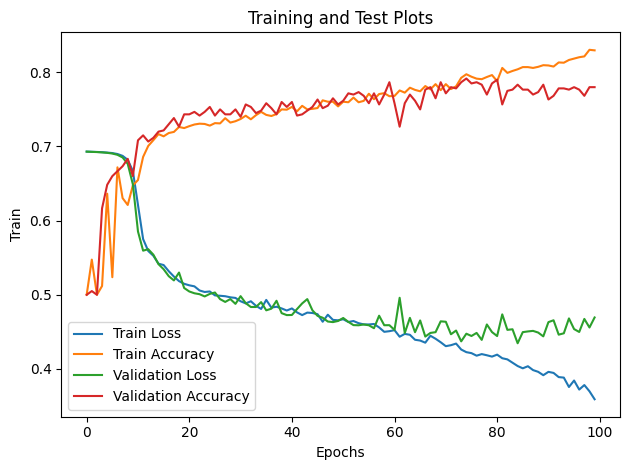

In [ ]:
fig, ax = plt.subplots()

ax.set_title('Training and Test Plots')
ax.plot(range(epochs), loss_train_history, label="Train Loss")
ax.plot(range(epochs), accuracy_train_history, label="Train Accuracy")
ax.plot(range(epochs), loss_val_history, label="Validation Loss")
ax.plot(range(epochs), accuracy_val_history, label="Validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()

In [ ]:
# vamos a salvar los ficheros a un lugar seguro local



## Exercise

---
Modify the notebook as necessary to improve the performance parameters of a model you create. Try to use a metric that combines the partial metrics to show that your model classifies better than the baseline model shown in this notebook. What you can modify includes:

---

### Instructions to Improve the Notebook (invest about it by yourself):

ChatGPT can be your great allied. Use it for your convenence.

1. **Data Preprocessing**: Improve data preprocessing by normalizing the data, handling missing values. Only for curiosity, you can use Transforms. Invest about it.

2. **Model Architecture**: Modify the architecture of the model. Experiment with different layers, activation functions, or network structures.

3. **Training Parameters**: Tune the training parameters such as learning rate, batch size, number of epochs, and optimization algorithms (e.g., Adam, SGD).

4. **Regularization Techniques**: Apply regularization techniques like dropout, L1/L2 regularization to prevent overfitting.

---
**End**

---


Or from a metrics file previously saved.

---
**Load previouos metric save to disk**

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [30]:
import os
HOME = os.getcwd() # Obtain actual directory
print(HOME)
datasets_dir = os.path.join(HOME, "datasets")

/content/datasets


In [31]:
import csv
import matplotlib.pyplot as plt

#
epochs = []
loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []
with open(datasets_dir+'/metrics_myCNN.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        epochs.append(int(row['Epoch']))
        loss_train_history.append(float(row['Train Loss']))
        accuracy_train_history.append(float(row['Train Accuracy']))
        loss_val_history.append(float(row['Val Loss']))
        accuracy_val_history.append(float(row['Val Accuracy']))

fig, ax = plt.subplots()

ax.set_title('Training and Test Plots')
ax.plot(range(len(epochs)), loss_train_history, label="Train Loss")
ax.plot(range(len(epochs)), accuracy_train_history, label="Train Accuracy")
ax.plot(range(len(epochs)), loss_val_history, label="Val Loss")
ax.plot(range(len(epochs)), accuracy_val_history, label="Val Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: '/content/datasets/datasets/metrics_myCNN.csv'

### Downloading/uploading files to/from your local file system (interactive way)

The files.download method will prompt the browser to download the file to your local computer.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv

# define the model
class myCNN(nn.Module):
    def __init__(self): # defines the constructor method __init__()
                        # for the myCNN class. This method is called
                        # when an instance of the class is created.
        super().__init__() # calls the constructor of the parent class
                           # (nn.Module) using Python's super() function.
                           # It initializes the parent class, allowing the
                           # myCNN class to inherit functionality from nn.Module.

        self.network = nn.Sequential(

            # Layer 1: Conv2d
            # Input: (batch_size, 3, 64, 64)
            # Output: (batch_size, 32, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Layer 2: Conv2d
            # Input: (batch_size, 32, 64, 64)
            # Output: (batch_size, 64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 3: MaxPool2d
            # Input: (batch_size, 64, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.MaxPool2d(2, 2),

            # Layer 4: Conv2d
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 5: Conv2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 6: MaxPool2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.MaxPool2d(2, 2),

            # Layer 7: Conv2d
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 8: Conv2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 9: MaxPool2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.MaxPool2d(2, 2),

            # Layer 10: Flatten
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 16384)
            nn.Flatten(),

            # Layer 11: Linear
            # Input: (batch_size, 16384)
            # Output: (batch_size, 128)
            nn.Linear(16384, 128),
            nn.ReLU(),

            # Layer 12: Linear
            # Input: (batch_size, 128)
            # Output: (batch_size, 64)
            nn.Linear(128, 64),
            nn.ReLU(),

            # Layer 13: Linear
            # Input: (batch_size, 64)
            # Output: (batch_size, 2)
            nn.Linear(64, 2)
        )
    # The forward method takes a single argument xb,
    # which represents the input data to the neural network.
    # Inside the forward method, the input xb is passed through the
    # neural network layers defined in self.network. The result of this
    # computation is then returned as the output of the forward method.
    def forward(self, xb):
        return self.network(xb)

# Mover el modelo al dispositivo adecuado después de cargar el estado
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = myCNN().to(device)
# Verificar si se está usando nn.DataParallel y reconfigurar si es necesario
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

# Definir el criterio de pérdida
criterion = nn.CrossEntropyLoss()

# Definir el optimizador
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# Cargar el checkpoint
checkpoint = torch.load(datasets_dir+"/myCNN.pth", map_location=device)

# Restaura el estado del modelo
model.load_state_dict(checkpoint['model'])

# Restaura el estado del optimizador
optimizer.load_state_dict(checkpoint['optimizer'])



print("Model and optimizer loaded successfully.")
print(model)

Using cpu device
Model and optimizer loaded successfully.
myCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=128, bias

In [ ]:
# ?????????????

import torch
import torch.optim as optim

# Inicializa el modelo
model = myCNN()

# Inicializa el optimizador, supongamos que es Adam
optimizer = optim.Adam(model.parameters())

# Carga el checkpoint
checkpoint = torch.load("myCNN.pth")

# Restaura el estado del modelo
model.load_state_dict(checkpoint['model'])

# Restaura el estado del optimizador
optimizer.load_state_dict(checkpoint['optimizer'])

print("Modelo y optimizador cargados exitosamente.")


KeyError: 'step'

In [ ]:
#???????

from google.colab import files

files.download('myCNN.pth')
files.download('metrics_myCNN.csv')

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      /tmp/pip-install-b05e68jn/pandas_10df0fdfdabc4873938586ff32a87249/setup.py:12: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        import pkg_resources
      /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/setuptools/__init__.py:81: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
      error in pandas setup

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#?????????
from google.colab import files

model = files.upload()
uploaded_csv = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#????????
from google.colab import files

ModuleNotFoundError: No module named 'google.colab'

In [ ]:

import csv
import matplotlib.pyplot as plt

# upload file from local system
#uploaded_csv = files.upload()

# Get the name of the uploaded file
file_name = next(iter(uploaded_csv))

# Open the CSV file from the `uploaded` variable
csvfile = uploaded_csv[file_name].decode('utf-8').splitlines()

# Read the data from the CSV file
reader = csv.DictReader(csvfile)
epochs = []
loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []
for row in reader:
    epochs.append(int(row['Epoch']))
    loss_train_history.append(float(row['Train Loss']))
    accuracy_train_history.append(float(row['Train Accuracy']))
    loss_val_history.append(float(row['Val Loss']))
    accuracy_val_history.append(float(row['Val Accuracy']))

# Create the plot
fig, ax = plt.subplots()
ax.set_title('Training and Test Plots')
ax.plot(epochs, loss_train_history, label="Train Loss")
ax.plot(epochs, accuracy_train_history, label="Train Accuracy")
ax.plot(epochs, loss_val_history, label="Val Loss")
ax.plot(epochs, accuracy_val_history, label=" Val Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()
fig.tight_layout()
plt.show()


NameError: name 'uploaded_csv' is not defined

## Validating our model

Once you've trained a model with a training dataset (train set) and evaluated it with a val dataset (val set), it can be useful to perform additional check using a test dataset (test set). Test with a test dataset is used to fine-tune the model's hyperparameters and prevent overfitting.

Here's a brief explanation of what test with a test dataset means and how it's done:

1. **Meaning of validation with a validation dataset:**
   - Validation with a validation dataset involves splitting your available data into three sets: training (train set), validation (val set), and testing (test set).
   - After training the model with the training set, its performance is evaluated using the validation set.
   - The idea is to adjust the model's hyperparameters (such as learning rate, batch size, neural network depth, etc.) based on its performance on the validation set. This helps prevent overfitting to the training set and improves the model's ability to generalize to unseen data.

2. **How validation with a validation dataset is done:**
   - After splitting your data into training and testing sets, an additional portion of the data is reserved for the validation set.
   - The size of this validation set can vary depending on the total size of your data and your specific needs, but typically around 10% to 20% of the data is reserved.
   - You then train the model using the training set and evaluate it using the validation set.
   - You can adjust the model's hyperparameters, as mentioned earlier, and repeat the training and validation process until you're satisfied with the model's performance on the validation set.
   - Finally, after tuning and validating your model, you evaluate its final performance using the test set to obtain an unbiased estimate of its performance on unseen data.

Validation with a validation dataset is a common practice in machine learning model development and is crucial for building models that generalize well to new, unseen data.

In [ ]:
# Supongamos que tienes tu modelo entrenado y los conjuntos de datos divididos
val_dataloader = DataLoader(
  val_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)


import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Define una función para obtener las predicciones del modelo
def obtener_predicciones(modelo, dataloader):
    preds = []
    etiquetas = []
    for batch in dataloader:
        inputs, etiquetas_batch = batch
        inputs = inputs.to(device)  # Si estás utilizando GPU, mueve los datos a la GPU
        outputs = modelo(inputs)
        _, predicciones = torch.max(outputs, 1)
        preds.extend(predicciones.tolist())
        etiquetas.extend(etiquetas_batch.tolist())
    return preds, etiquetas

# Define el dispositivo (CPU o GPU) en el que se realizarán las operaciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo guardado
model_file = "myCNN.pth"
checkpoint = torch.load(model_file, map_location=device)
model_state_dict = checkpoint['model']

# Supongamos que 'val_dataloader' es tu DataLoader de validación

# Definir y cargar el modelo
# Asegúrate de definir tu modelo adecuadamente
model = myCNN()
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

# Obtén las predicciones del modelo y las etiquetas verdaderas del conjunto de validación
predicciones_val, etiquetas_val = obtener_predicciones(model, val_dataloader)

# Calcular la matriz de confusión
cm = confusion_matrix(etiquetas_val, predicciones_val)

# Extraer los valores de la matriz de confusión
tn, fp, fn, tp = cm.ravel()

# Imprimir los valores
print("Verdaderos negativos (TN):", tn)
print("Falsos positivos (FP):", fp)
print("Falsos negativos (FN):", fn)
print("Verdaderos positivos (TP):", tp)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Verdaderos negativos (TN): 238
Falsos positivos (FP): 62
Falsos negativos (FN): 85
Verdaderos positivos (TP): 215


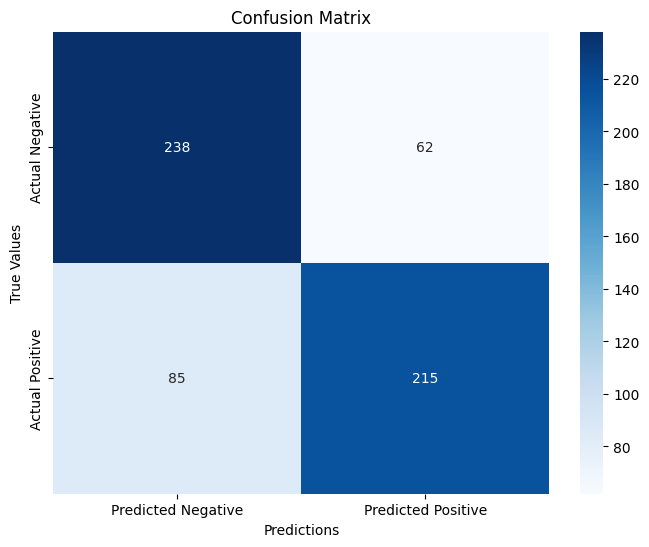

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'etiquetas_val' are the true labels and 'predicciones_val' are the model predictions

# Calculate the confusion matrix
cm = confusion_matrix(etiquetas_val, predicciones_val)

# Create a Pandas DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.show()


Además de la matriz de confusión, hay varias estadísticas que podrían ser útiles para evaluar el rendimiento de un modelo de clasificación. Aquí hay algunas opciones que podrías considerar:

1. **Precisión (Accuracy):** La proporción de predicciones correctas entre el total de predicciones.
   ```python
   from sklearn.metrics import accuracy_score
   accuracy = accuracy_score(etiquetas_val, predicciones_val)
   print("Accuracy:", accuracy)
   ```

2. **Precisión (Precision):** La proporción de verdaderos positivos entre el total de predicciones positivas.
   ```python
   from sklearn.metrics import precision_score
   precision = precision_score(etiquetas_val, predicciones_val)
   print("Precision:", precision)
   ```

3. **Recall (Sensitivity o True Positive Rate):** La proporción de verdaderos positivos entre el total de valores positivos reales.
   ```python
   from sklearn.metrics import recall_score
   recall = recall_score(etiquetas_val, predicciones_val)
   print("Recall:", recall)
   ```

4. **Puntuación F1 (F1 Score):** La media armónica de precision y recall, proporciona un equilibrio entre ambas métricas.
   ```python
   from sklearn.metrics import f1_score
   f1 = f1_score(etiquetas_val, predicciones_val)
   print("F1 Score:", f1)
   ```

Estas estadísticas proporcionan diferentes perspectivas sobre el rendimiento del modelo y pueden ser útiles en diferentes contextos. Puedes elegir las que mejor se ajusten a tus necesidades de evaluación.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy: The proportion of correct predictions among the total predictions
accuracy = accuracy_score(etiquetas_val, predicciones_val)
print("Accuracy:", accuracy)

# Precision: The proportion of true positives among the total positive predictions
precision = precision_score(etiquetas_val, predicciones_val)
print("Precision:", precision)

# Recall (Sensitivity or True Positive Rate): The proportion of true positives among the total actual positives
recall = recall_score(etiquetas_val, predicciones_val)
print("Recall:", recall)

# F1 Score: The harmonic mean of precision and recall, provides a balance between both metrics
f1 = f1_score(etiquetas_val, predicciones_val)
print("F1 Score:", f1)


Accuracy: 0.755
Precision: 0.776173285198556
Recall: 0.7166666666666667
F1 Score: 0.7452339688041594


In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(etiquetas_val, predicciones_val)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.74      0.79      0.76       300
           1       0.78      0.72      0.75       300

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.75       600
weighted avg       0.76      0.76      0.75       600



In [ ]:
import pandas as pd

# Convertir el informe de clasificación en un DataFrame de Pandas
report_df = pd.DataFrame(classification_report(etiquetas_val, predicciones_val, output_dict=True))

# Transponer el DataFrame para tener las métricas como columnas y las clases como filas
report_df = report_df.transpose()

# Mostrar el DataFrame
print(report_df)


              precision    recall  f1-score  support
0              0.736842  0.793333  0.764045  300.000
1              0.776173  0.716667  0.745234  300.000
accuracy       0.755000  0.755000  0.755000    0.755
macro avg      0.756508  0.755000  0.754639  600.000
weighted avg   0.756508  0.755000  0.754639  600.000


In [ ]:
import pandas as pd

# Convertir el informe de clasificación en un DataFrame de Pandas
report_df = pd.DataFrame(classification_report(etiquetas_val, predicciones_val, output_dict=True))

# Transponer el DataFrame para tener las métricas como columnas y las clases como filas
report_df = report_df.transpose()

# Crear una función para resaltar las celdas
def resaltar_celdas(valor):
    if isinstance(valor, float) and valor > 0.8:
        return 'background-color: yellow'
    else:
        return ''

# Aplicar el estilo al DataFrame
styled_report = report_df.style.applymap(resaltar_celdas)

# Mostrar el DataFrame estilizado
styled_report


,precision,recall,f1-score,support
0,0.736842,0.793333,0.764045,300.000000
1,0.776173,0.716667,0.745234,300.000000
accuracy,0.755000,0.755000,0.755000,0.755000
macro avg,0.756508,0.755000,0.754639,600.000000
weighted avg,0.756508,0.755000,0.754639,600.000000
